Dataset --> https://www.kaggle.com/abdallahalidev/plantvillage-dataset

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import MobileNet

In [3]:
DATA_PATH = '../input/plantvillage-dataset/color'
BATCH_SIZE_PER_REPLICA = 32
input_shape = (256, 256, 3)
classes = 38

In [4]:
# import images
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  label_mode='categorical',
  seed = 123,
  subset="training",
  image_size=(256, 256),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  label_mode='categorical',
  seed = 123,
  subset="validation",
  image_size=(256, 256),
  batch_size=BATCH_SIZE)


Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [ ]:
import pickle
model = pickle.load(open('models/model.h5', 'rb'))
model1 = pickle.load(open('models/model1.h5', 'rb'))

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
def plot_metrics(accuracy, loss, val_accuracy, val_loss, xlim):
    fig, ax = plt.subplots(1, 2, figsize = (16, 7))

    ax[0].plot([0]+accuracy, label = 'Accuracy')
    ax[0].plot([0]+loss, label = 'Loss')
    ax[0].set_title('Train')
    ax[0].set(xlabel='epochs')
    ax[0].set_xlim([1,xlim])
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot([0]+val_accuracy, label = 'Accuracy')
    ax[1].plot([0]+val_loss, label = 'Loss')
    ax[1].set_title('Validation')
    ax[1].set(xlabel='epochs')
    ax[1].set_xlim([1,xlim])
    ax[1].grid(True)
    ax[1].legend()

### 1st model

In [7]:
def set_callbacks():
    # initiate reduce learning rate class
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=1, min_lr=0.0001)

    #Early stop training
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1,
        mode='auto', baseline=None, restore_best_weights=True)
    
    return [reduce_lr, early_stopping]

In [8]:
def fully_connected_layers(x):
    x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x=Dropout(.2)(x)
    x=Dense(1024,activation='relu')(x) #dense layer 2
    x=Dropout(.2)(x)
    x=Dense(512,activation='relu')(x) #dense layer 3
    x=Dropout(.2)(x)
    preds=Dense(classes,activation='softmax')(x) #final layer with softmax activation
    return preds

In [9]:
input_shape = (256, 256, 3)
classes = 38

base_model=MobileNet(input_shape = input_shape, weights='imagenet',include_top=False, pooling = 'avg') #imports the mobilenet model and discards the last 1000 neuron layer.

# rescale images layer

new_input = tf.keras.Input(shape=(256, 256, 3))
image_rescale = keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./255),
    ])
rescaled_images = image_rescale(new_input)

x = base_model(rescaled_images) 
#x=Flatten(name='flatten')(base_model.output)
preds = fully_connected_layers(x)

model=Model(inputs=new_input,outputs=preds)

for layer in model.layers[2:3]:
    layer.trainable=False

model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
______________________________________________________________

### Train model

In [19]:
batch_size = 32
EPOCHS = 10

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)

callbacks = set_callbacks()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


with tf.device('/gpu:0'):
    hist = model.fit(train_ds,
                  #batch_size=batch_size,
                  epochs=EPOCHS,
                  validation_data=val_ds,
                  callbacks = callbacks,
                  shuffle=True)
    
accuracy, loss, val_accuracy, val_loss = hist.history['accuracy'], hist.history['loss'], hist.history['val_accuracy'], hist.history['val_loss'] 


Epoch 1/2
1358/1358 [==============================] - 452s 332ms/step - loss: 0.3985 - accuracy: 0.8923 - val_loss: 0.2939 - val_accuracy: 0.9278
Epoch 2/2
1358/1358 [==============================] - 139s 102ms/step - loss: 0.3094 - accuracy: 0.9255 - val_loss: 0.2625 - val_accuracy: 0.9353


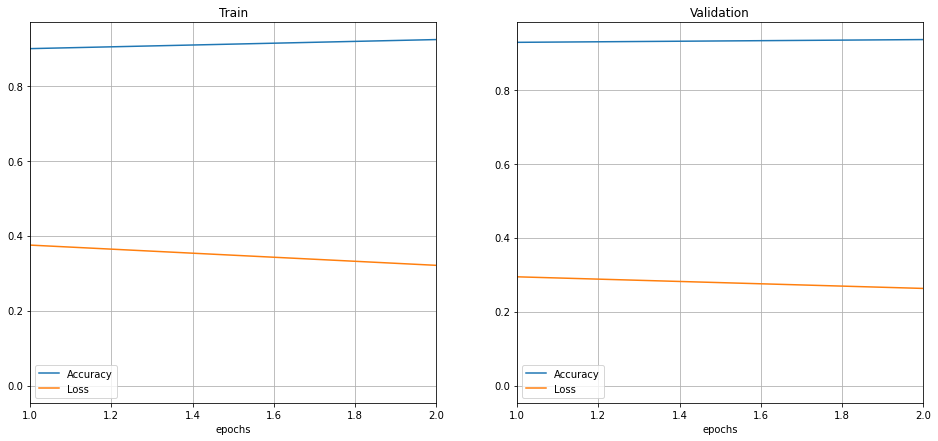

In [40]:
plot_metrics(accuracy, loss, val_accuracy, val_loss, EPOCHS)

In [ ]:
model.save('models/model.h5')

### 2nd Model (with augmented images)

In [ ]:
base_model1=MobileNet(input_shape = input_shape, weights='imagenet',include_top=False, pooling = 'avg') #imports the mobilenet model and discards the last 1000 neuron layer.

# augment images

new_input = tf.keras.Input(shape=(256, 256, 3))
data_augmentation = keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./255),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor = 0.1)
    ])
augmented_images = data_augmentation(new_input)

x = base_model1(augmented_images)  #new
#x=Flatten(name='flatten')(base_model.output)

preds = fully_connected_layers(x)

model1=Model(inputs=new_input,outputs=preds)


for layer in model1.layers[2:3]:
    layer.trainable=False


model1.summary()

#### Train model

In [ ]:
batch_size = 32
EPOCHS = 10

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)

callbacks = set_callbacks()


# Let's train the model using RMSprop
model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

with tf.device('/gpu:0'):
    history_augm = model1.fit(train_ds,
                  #batch_size=batch_size,
                  epochs=EPOCHS,
                  validation_data=val_ds,
                  callbacks = callbacks,
                  shuffle=True
                             )

accuracy, loss, val_accuracy, val_loss = history_augm.history['accuracy'], history_augm.history['loss'], history_augm.history['val_accuracy'], history_augm.history['val_loss'] 


In [ ]:
plot_metrics(accuracy, loss, val_accuracy, val_loss)

In [ ]:
model1.save('models/model1.h5')

In [ ]:
#LOSS
loss = tf.keras.losses.SparseCategoricalCrossentropy()
#ACCURACY
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

#### The two models have very close validation accuracies although the second model seems like it's less overfitted to the training data (lower training accuracy)

#### Let's examine the first model a bit further

In [21]:
y_pred_prob = model.predict(val_ds)

In [22]:
np.argmax(y_pred_prob,axis=1)

array([30, 33, 29, ..., 37, 37, 37])

In [23]:
y_true = []
conf_matrix = np.zeros((38, 38), int)
for batch, labels in val_ds:
    y_pred_class = np.argmax(model.predict(batch), axis = 1)
    y_true_class = np.argmax(labels, axis = 1)
    for pred_val, true_val in zip(y_pred_class, y_true_class):
        conf_matrix[pred_val][true_val] += 1


#### Let's calculate the confussion matrix to see the model weaknesses

In [24]:
n=38
'{} correct predictions out of {} samples.'.format(sum(conf_matrix[i][i] for i in range(n)), '10861')

'10158 correct predictions out of 10861 samples.'

In [25]:
import pandas as pd

conf_matrix_df = pd.DataFrame(data = conf_matrix)
conf_matrix_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,105,0,0,0,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
1,0,120,5,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,47,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,11,0,1,343,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,316,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,205,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,2,0,1,0,0,147,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,69,0,5,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,238,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,40,0,193,...,1,0,0,0,0,0,0,0,0,0


Rows correspond to the true values and columns to the predicted values

In [36]:
import os
directory = '../input/plantvillage-dataset/color'
folders = [x[0] for x in os.walk(directory)]

In [35]:
maxval = 0
for row in range(38):
    for col in range(38):
        if(row!=col & conf_matrix[row][col] > maxval):
            maxval = conf_matrix[row][col]
            maxr = row
            maxc = col
true = folders[maxr + 1][len(directory)+1:]
prediction = folders[maxc + 1][len(directory)+1:]     

'We have misclassified {} times the {} as {}'.format(maxval, true, prediction)

'We have misclassified 69 times the Corn_(maize)___Northern_Leaf_Blight as Corn_(maize)___Northern_Leaf_Blight'